# Logistic Regression - Lab

In this alb we'll look at some food data, specifically nutritional content. Nutritional content of a food item (like salt, sugar, calories, etc.) leads to a category like 'In Moderation', 'less often', 'more often'

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay, precision_recall_fscore_support, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## EDA

The data has the following properties:

- There are 18 columns (17 feature columns, 1 target column)
- All feature columns are numeric (10 float and 7 integer)
- The target column is a string and contains the following categories: ['In Moderation', 'Less Often', 'More Often']
- There are a total of 13260 food items listed.
- The distribution of categories is *not* equivalent across classes
- The data is not scaled/normalised.

In [3]:
df = pd.read_csv("./data/food_items.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13260 entries, 0 to 13259
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Calories             13260 non-null  float64
 1   Total Fat            13260 non-null  int64  
 2   Saturated Fat        13260 non-null  float64
 3   Monounsaturated Fat  13260 non-null  float64
 4   Polyunsaturated Fat  13260 non-null  float64
 5   Trans Fat            13260 non-null  float64
 6   Cholesterol          13260 non-null  int64  
 7   Sodium               13260 non-null  float64
 8   Total Carbohydrate   13260 non-null  float64
 9   Dietary Fiber        13260 non-null  float64
 10  Sugars               13260 non-null  float64
 11  Sugar Alcohol        13260 non-null  int64  
 12  Protein              13260 non-null  float64
 13  Vitamin A            13260 non-null  int64  
 14  Vitamin C            13260 non-null  int64  
 15  Calcium              13260 non-null 

In [8]:
feature_cols = list(df.columns[:-1])
feature_cols

['Calories',
 'Total Fat',
 'Saturated Fat',
 'Monounsaturated Fat',
 'Polyunsaturated Fat',
 'Trans Fat',
 'Cholesterol',
 'Sodium',
 'Total Carbohydrate',
 'Dietary Fiber',
 'Sugars',
 'Sugar Alcohol',
 'Protein',
 'Vitamin A',
 'Vitamin C',
 'Calcium',
 'Iron']

In [10]:
df['class'].value_counts(normalize=True)

class
'In Moderation'    0.501433
'Less Often'       0.423906
'More Often'       0.074661
Name: proportion, dtype: float64

<Axes: xlabel='class'>

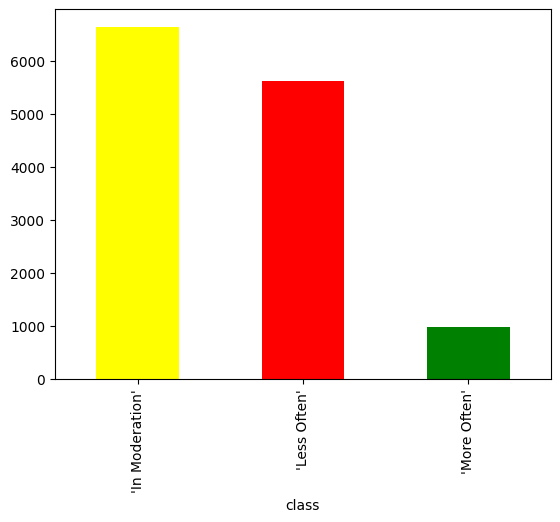

In [11]:
df['class'].value_counts().plot.bar(color=['yellow', 'red', 'green'])

## Feature Engineering

Let's split the data up in X (features) and y (target) and apply some basic feature preparation:
- Scaling
- Categorical encoding
- train/test split (making sure to stratify on the category to maintain equal proportions between test and train sets.)

In [24]:
scaler = MinMaxScaler()
label_encoder = LabelEncoder()

X = scaler.fit_transform(df[feature_cols])
print(f"The range of feature inputs are within {X.min()} to {X.max()}")
y = label_encoder.fit_transform(df['class'])
print(f"The categories are {np.unique(y)}, corresponding to {label_encoder.classes_}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

The range of feature inputs are within 0.0 to 1.0
The categories are [0 1 2], corresponding to ["'In Moderation'" "'Less Often'" "'More Often'"]
Training dataset shape, X_train: (10608, 17), y_train: (10608,)
Testing dataset shape, X_test: (2652, 17), y_test: (2652,)


## Training a model

Now we can train a linear model to this. First, let's define an evaluation function:

In [25]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

Then set up the parametrisation and the model itself.

In [31]:
# Use L2 regularization
penalty = 'l2'
# In which case we'll have to use the 'lbfgs' solver
solver = 'lbfgs'
max_iter = 1000

l2_model = LogisticRegression(
    random_state=42, 
    penalty=penalty,
    solver=solver,
    max_iter=max_iter
    )

l2_model.fit(X_train, y_train)
l2_preds = l2_model.predict(X_test)

evaluate_metrics(y_test, l2_preds)

{'accuracy': 0.7801659125188537,
 'recall': array([0.88345865, 0.74021352, 0.31313131]),
 'precision': array([0.73300062, 0.85071575, 0.87323944]),
 'f1score': array([0.80122741, 0.79162702, 0.46096654])}

As we can see from the results, the overall accuracy is around 78%. For precision, recall and f1 score the values for the first two classes are equivalent ($\pm$ 10%). However, for the underrepresented 'More Often' class, the scores are quite bad.

We can try again with another regularisation strategy:

In [32]:
# Use L2 regularization
penalty = 'l1'
# In which case we'll have to use the 'saga' solver
solver = 'saga'
max_iter = 1000

l1_model = LogisticRegression(
    random_state=42, 
    penalty=penalty,
    solver=solver,
    max_iter=max_iter
    )

l1_model.fit(X_train, y_train)
l1_preds = l1_model.predict(X_test)

evaluate_metrics(y_test, l1_preds)

{'accuracy': 0.8190045248868778,
 'recall': array([0.87142857, 0.74644128, 0.87878788]),
 'precision': array([0.79274966, 0.85963115, 0.81308411]),
 'f1score': array([0.83022923, 0.79904762, 0.84466019])}

This performs much better. This might be due to the l1 regularisation, which has a chance to reduce coefficients to 0, in which case the model becomes simplified and is less prone to overfitting. We can easily inspect the truth of this:

In [44]:
l1_idx = pd.MultiIndex(levels=[['l1'], [0, 1, 2]], codes=[[0, 0, 0], [0, 1, 2]])
l2_idx = pd.MultiIndex(levels=[['l2'], [0, 1, 2]], codes=[[0, 0, 0], [0, 1, 2]])

pd.concat(
    [
    pd.DataFrame(l1_model.coef_.T, columns=l1_idx), 
    pd.DataFrame(l2_model.coef_.T, columns=l2_idx)
    ], axis=1)

l1                               l2                      
            0          1           2         0          1          2
0   12.394251   0.000000 -111.725762  8.410698   2.379756 -10.790455
1    0.000000   4.994217  -28.858470  1.907195   6.568741  -8.475935
2    0.000000  23.219467    0.000000 -7.634461  10.810983  -3.176522
3    5.897042   0.000000    0.000000  2.798833  -2.020174  -0.778659
4    0.000000   0.000000    0.000000  0.601607  -0.501694  -0.099913
5   -4.380089   0.000000    0.000000 -1.796219   1.987857  -0.191638
6    0.000000   6.494982    0.000000 -2.199374   3.580295  -1.380921
7    0.682223   0.000000   -1.263289  0.573436  -0.076250  -0.497185
8    0.000000   2.386331  -37.827346  5.337566   4.234677  -9.572242
9   21.511422  -8.361610    0.000000  2.251933  -1.699522  -0.552411
10   0.000000  14.968375   -3.629287 -2.981025  10.297755  -7.316729
11   0.000000   3.307319    0.000000 -0.979217   2.047093  -1.067875
12   4.441919   0.000000   -0.740075  5.133167   0.298313  -5.431480
13   0.000000  -2.045561    0.000000  0.852997  -1.513973   0.660977
14   0.000000   0.000000    0.000000 -0.067106   0.111656  -0.044550
15   1.573453  -0.087107    0.000000  1.481587   0.564532  -2.046119
16   0.000000   0.000000    0.000000  1.473713   0.322236  -1.795949

Indeed we can see that in the L1 model many coefficients are set to 0.

## Confusion Matrix

Let's also take a look at the confusion matrix:

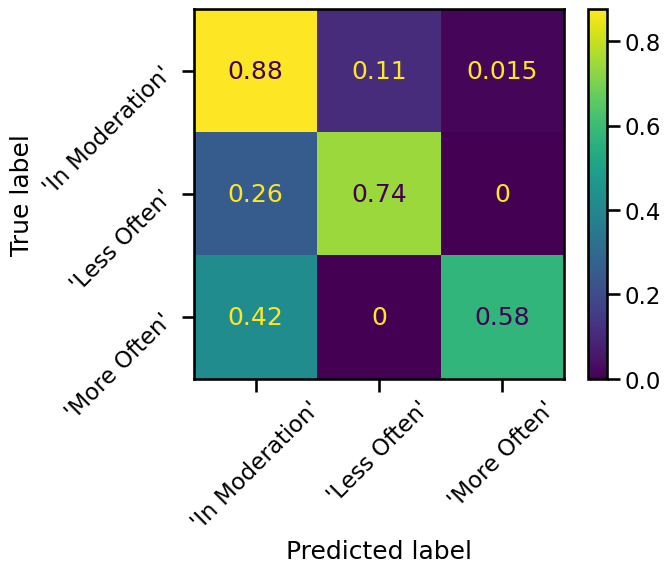

In [57]:
cf = confusion_matrix(y_test, l1_preds, normalize='true')
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=label_encoder.classes_)
disp.plot()
disp.ax_.tick_params(labelrotation=45)
plt.show()

## Interpreting results

As with previous models,m we can inspect the coefficients and see how they impact the result. with some helper functions below we take the coefficients that are larger in magnitude than 0.1 and plot them. Since the output is categorical, using a sigmoid function to determine the category, the absolute magnitude is less important than in linear regression. But there is still much insight in the relative size of the coefficients.

In [46]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, label_index, columns):
    coef_dict = {}
    for coef, feat in zip(regression_model.coef_[label_index, :], columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')
    return color_vals

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')
    plt.show()

We can grab the coefficients for each class and determine the impact. For the category `Less Often`, we can see that there is a large dependence on sugar and saturated fats. Which is to be expected.

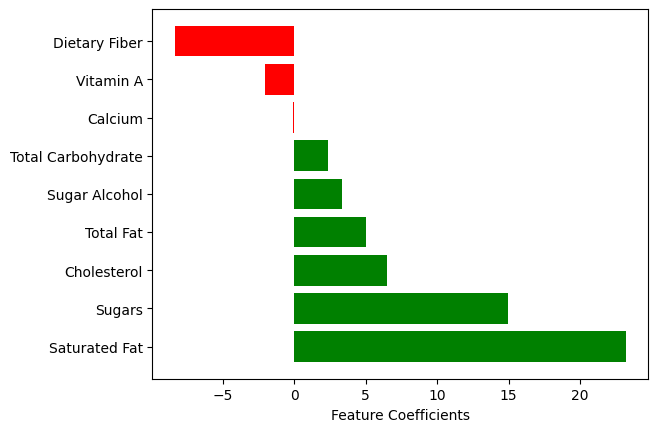

In [47]:
coef_dict = get_feature_coefs(l1_model, 1, feature_cols)
visualize_coefs(coef_dict)

We can do the same for the `More Often` category. Which results in a large negative dependence on calories. There are no large positive features contributing to this category. This may be due to the relatively low sampling of this category.

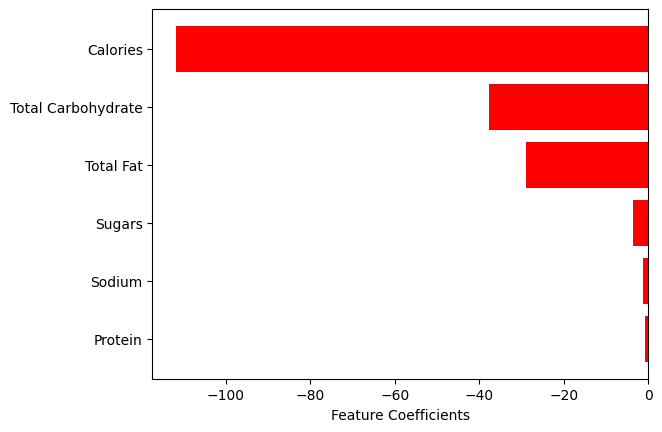

In [48]:
coef_dict = get_feature_coefs(l1_model, 2, feature_cols)
visualize_coefs(coef_dict)

## Training logistic regression with ElasticNet

Besides using l1 or l2 regularization direclty, we can also mix between them. This is called ElasticNet. ElasticNet will find a proper middle ground between L1 and L2 regularization.

In [51]:
# Use L2 regularization
penalty = 'elasticnet'
l1_ratio = 0.5
# In which case we'll have to use the 'saga' solver
solver = 'saga'
max_iter = 1000

en_model = LogisticRegression(
    random_state=42, 
    penalty=penalty,
    solver=solver,
    max_iter=max_iter,
    l1_ratio=l1_ratio
    )

en_model.fit(X_train, y_train)
en_preds = en_model.predict(X_test)

evaluate_metrics(y_test, en_preds)

{'accuracy': 0.797134238310709,
 'recall': array([0.87518797, 0.74377224, 0.57575758]),
 'precision': array([0.7578125 , 0.85132383, 0.85074627]),
 'f1score': array([0.81228193, 0.79392213, 0.68674699])}

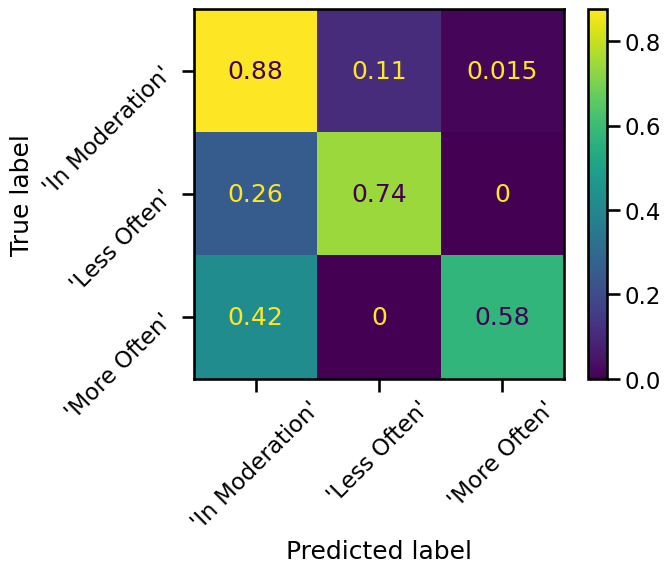

In [56]:
cf = confusion_matrix(y_test, en_preds, normalize='true')
sns.set_context('talk')
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=label_encoder.classes_)
disp.plot()
disp.ax_.tick_params(labelrotation=45)
plt.show()

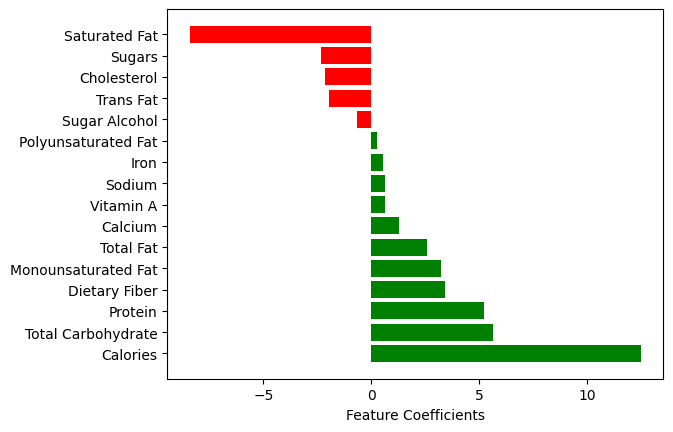

In [58]:
coef_dict = get_feature_coefs(en_model, 0, feature_cols)
visualize_coefs(coef_dict)

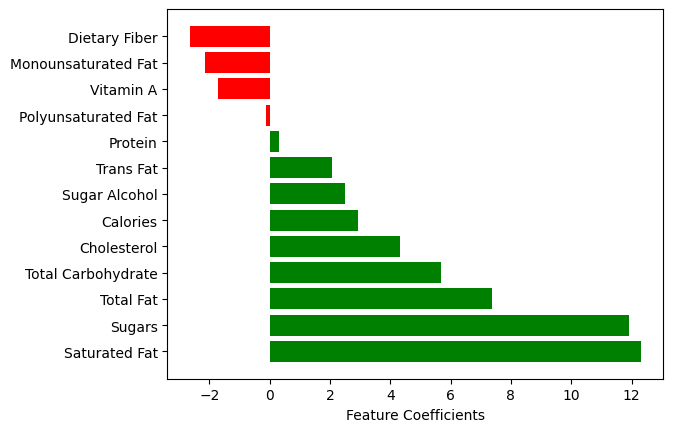

In [59]:
coef_dict = get_feature_coefs(en_model, 1, feature_cols)
visualize_coefs(coef_dict)

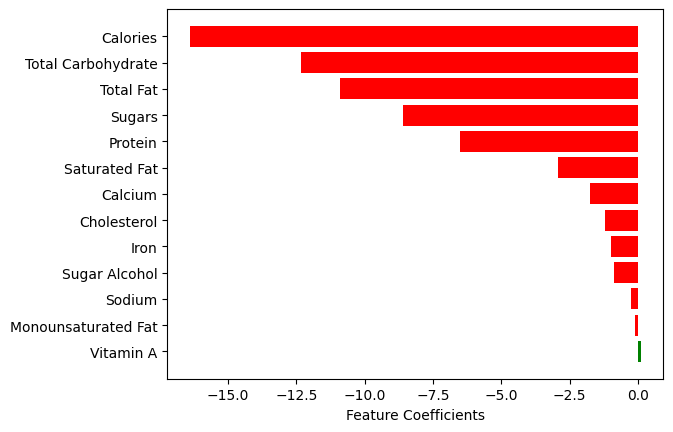

In [60]:
coef_dict = get_feature_coefs(en_model, 2, feature_cols)
visualize_coefs(coef_dict)